# I. Importations des modules et des données
## 1.1 Importation des modules

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from zipfile import ZipFile
import shutil
import glob

## 1.2 Extraction des données

In [16]:
# allow_extraction = False
# datasets_path = r"C:\Users\axelb\Desktop\Projet DS\Datasets"
# extracted_datasets_path = os.path.join(datasets_path,'Extracted')
# new_dataset_filename = "Other"
# new_dataset_path = os.path.join(extracted_datasets_path, new_dataset_filename)
# datasets_to_regroup = ['Dataset','Painting','Schematics','Sketch','Text']

# if allow_extraction:
#     try:
#         for dataset_filename in os.listdir(datasets_path):

#             dataset_path = os.path.join(datasets_path, dataset_filename)
#             dataset_zip = ZipFile(dataset_path, 'r')

#             if not os.path.exists(extracted_datasets_path):
#                 os.makedirs(extracted_datasets_path)
#                 print(f"Extraction folder successfully created at '{extracted_datasets_path}'")

#             print(f"Starting the extraction of '{dataset_filename}' at '{extracted_datasets_path}'")
#             dataset_zip.extractall(extracted_datasets_path)
#             print(f"'{dataset_filename}' was successfully extracted at '{extracted_datasets_path}'")

#         dataset_zip.close()
#     except:
#         pass
    
#     if not os.path.exists(new_dataset_path):
#         os.makedirs(new_dataset_path)
#         print(f"New folder successfully created at '{new_dataset_path}'")
#     for dataset in os.listdir(extracted_datasets_path):
#         if dataset in datasets_to_regroup:
#             dataset_directory = os.path.join(extracted_datasets_path, dataset)
#             print(f"Starting the copy of '{dataset_directory}' at '{new_dataset_path}'")
#             shutil.copytree(dataset_directory, new_dataset_path, copy_function=shutil.move, dirs_exist_ok=True)
#             print(f"'The content of {dataset_directory}' was successfully extracted at '{new_dataset_path}'")
#             shutil.rmtree(dataset_directory)

In [17]:
project_path = r"..\Datasets_train_test"
train_dir = project_path + r"\train"
test_dir = project_path + r"\test"

## 1.3 Pré-traitement des données

## Recherhce d'images  corrompues

In [18]:
allow_search_for_corrupted = True
bad_paths = []

if allow_search_for_corrupted:
    img_paths = glob.glob(os.path.join(r"..\Datasets_train_test",'*/*.*')) # assuming you point to the directory containing the label folders.

    
    for image_path in img_paths:
        try:
          img_bytes = tf.io.read_file(image_path)
          decoded_img = tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError as e:
          print(f"Found bad path {image_path}...{e}")
          bad_paths.append(image_path)

    print("BAD PATHS:")
    for bad_path in bad_paths:
        print(f"{bad_path}")

BAD PATHS:


In [19]:
for path in bad_paths:
    try:
        os.remove(path)
    except OSError as error:
        break

## 1.4 Importation des données

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')



Found 33124 images belonging to 2 classes.
Found 8281 images belonging to 2 classes.


In [21]:
# train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
#     project_path,
#     validation_split=0.2,
#     seed=10,
#     batch_size=128,
#     subset = "both"
# )
# print(f"\nThe dataset is composed of these classes : {train_set.class_names}")


In [22]:
# plt.figure(figsize=(8, 8))
# for images, labels in train_set.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i+1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(train_set.class_names[labels[i]])
#         plt.axis("off")
# plt.show()

# 2. Modélisation des données
## 2.1 Définition du modèle

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

## 2.2 Compilation du modèle 

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

## 2.3 Entrainement du modèle

Epoch 1/3
1036/1036 [==============================] - 308s 297ms/step - loss: 0.4004 - accuracy: 0.7799 - val_loss: 0.3680 - val_accuracy: 0.7779
Epoch 2/3
1036/1036 [==============================] - 314s 303ms/step - loss: 0.3612 - accuracy: 0.8064 - val_loss: 0.3325 - val_accuracy: 0.8276
Epoch 3/3
1036/1036 [==============================] - 308s 297ms/step - loss: 0.3451 - accuracy: 0.8188 - val_loss: 0.3224 - val_accuracy: 0.8359


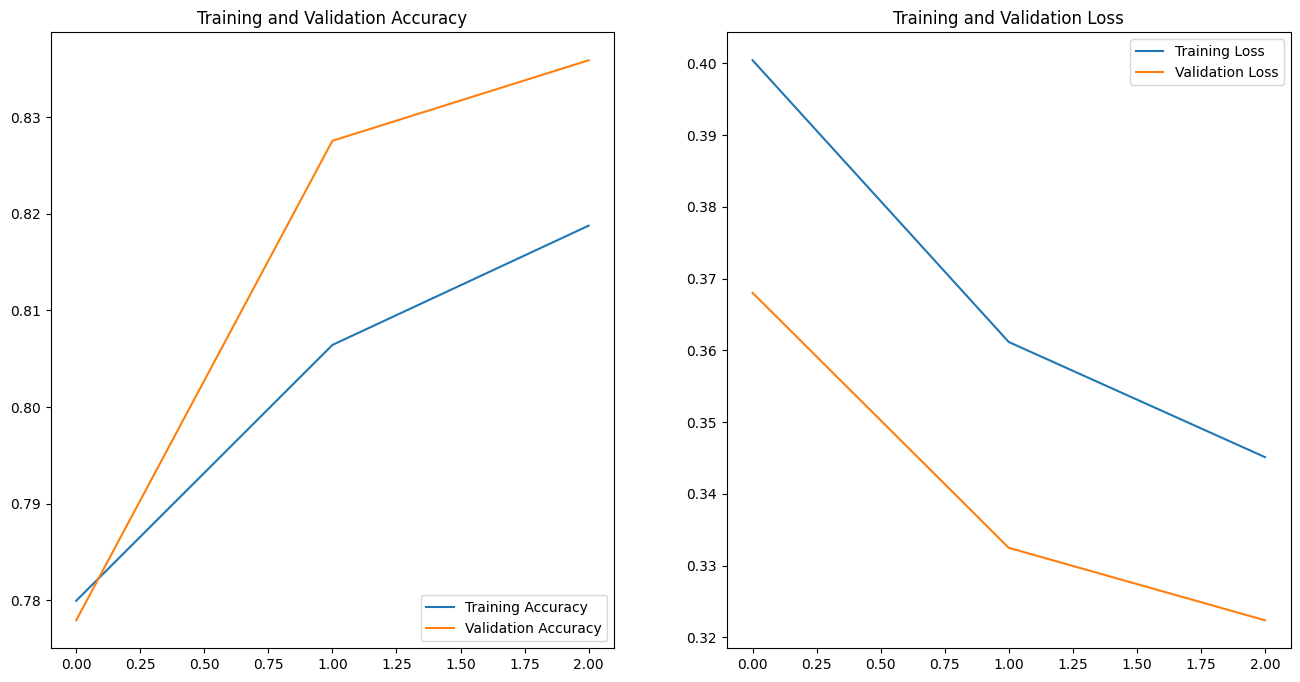

In [25]:
epochs = 3

history =  model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

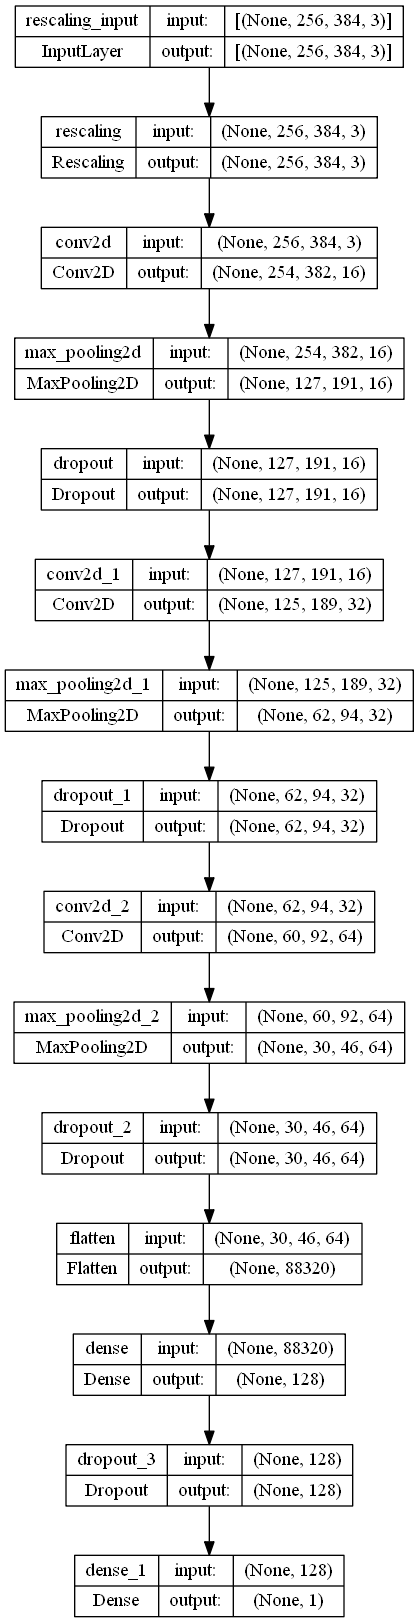

In [9]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)